In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Sep 11 21:22:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install keras-unet-collection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 7.1 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn

In [ ]:
! pip install -q tensorflow-model-optimization


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.4 MB/s eta 0:00:00


In [ ]:
!unzip "/content/drive/MyDrive/Data.zip" -d "/content"


Streaming output truncated to the last 5000 lines.
  inflating: /content/Data/train_masks/train/vienna9.tif_patch_12_3.tif  
  inflating: /content/Data/train_masks/train/chicago1.tif_patch_4_0.tif  
  inflating: /content/Data/train_masks/train/austin29.tif_patch_0_8.tif  
  inflating: /content/Data/train_masks/train/austin6.tif_patch_14_5.tif  
  inflating: /content/Data/train_masks/train/tyrol-w11.tif_patch_9_18.tif  
  inflating: /content/Data/train_masks/train/vienna20.tif_patch_3_10.tif  
  inflating: /content/Data/train_masks/train/chicago14.tif_patch_4_14.tif  
  inflating: /content/Data/train_masks/train/kitsap31.tif_patch_9_17.tif  
  inflating: /content/Data/train_masks/train/chicago2.tif_patch_1_1.tif  
  inflating: /content/Data/train_masks/train/chicago32.tif_patch_18_2.tif  
  inflating: /content/Data/train_masks/train/vienna8.tif_patch_9_0.tif  
  inflating: /content/Data/train_masks/train/austin32.tif_patch_10_14.tif  
  inflating: /content/Data/train_masks/train/tyrol-w

In [ ]:

import glob
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
from PIL import Image
import time
import keras
import tifffile as tiff
import cv2
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras_unet_collection import models, losses
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess



# Data Understanding

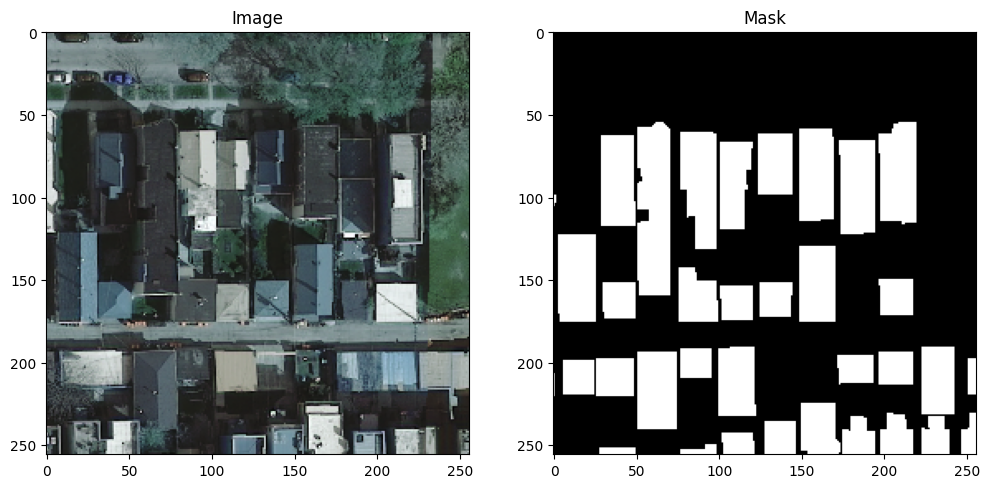

In [ ]:

train_img_dir = "/content/Data/train_images/train/"
train_mask_dir = "/content/Data/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


# Data preprocessing

In [ ]:
def create_generators( batch_size):
  seed = 42


    # trainig data generator arguments
  train_data_gen_args = dict(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )
   # val and test data generator arguments
  valid_data_gen_args = dict(
        rescale=1./255
    )

    # Create data generators -  val is used for both val and test generator
  train_data_generator = ImageDataGenerator(**train_data_gen_args)
  valid_data_generator = ImageDataGenerator(**valid_data_gen_args)


  image_generator = train_data_generator.flow_from_directory(
        "/content/Data/train_images/",
        seed=seed,
        batch_size=batch_size,
        class_mode=None,
        shuffle=True
    )

  mask_generator = train_data_generator.flow_from_directory(
        "/content/Data/train_masks/",
        seed=seed,
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode=None,
        shuffle=True
    )


  valid_img_generator = valid_data_generator.flow_from_directory(
        "/content/Data/val_images/",
        seed=seed,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )

  valid_mask_generator = valid_data_generator.flow_from_directory(
        "/content/Data/val_masks/",
        seed=seed,
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode=None,
        shuffle=False
    )


  def my_image_mask_generator(image_gen, mask_gen):
        while True:
            for (img, mask) in zip(image_gen, mask_gen):

                yield (img, mask)


  train_generator = my_image_mask_generator(image_generator, mask_generator)
  val_generator = my_image_mask_generator(valid_img_generator, valid_mask_generator)


  return train_generator, val_generator

In [ ]:
batch_size = 16
# generate train and validation data
train_generator, val_generator = create_generators(batch_size)

Found 29652 images belonging to 1 classes.
Found 29652 images belonging to 1 classes.
Found 3706 images belonging to 1 classes.
Found 3706 images belonging to 1 classes.


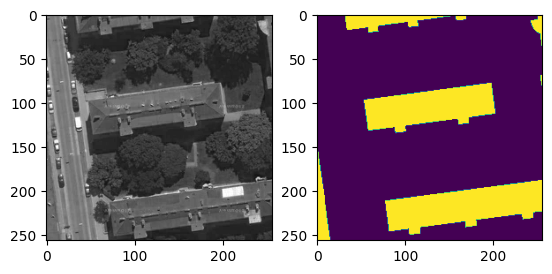

In [ ]:


x, y = next(train_generator)

for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [ ]:
print(x.shape)
print(y.shape)

(16, 256, 256, 3)
(16, 256, 256, 1)


# intialising hyper parmeter and other variables for all three models

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


#variables intialised aswell as learning rate scheduling and early stopping
image_height = x.shape[1]
image_width = x.shape[2]
image_channels = x.shape[3]
input_shape = (image_height, image_width, image_channels)

num_train_images = len(os.listdir("/content/Data/train_images/train/"))
num_val_images = len(os.listdir("/content/Data/val_images/val/"))

batch_size = 16




steps_per_epoch = (num_train_images + batch_size - 1) // batch_size
val_steps_per_epoch = (num_val_images + batch_size - 1) // batch_size
num_classes=1

epochs =  30



reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='min', restore_best_weights=True)




In [ ]:

from tensorflow.keras import backend as K
#IoU metric defintion
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# Clasical Unet

In [ ]:



model = models.unet_2d(input_shape, filter_num=[64, 128, 256, 512, 1024], n_labels=num_classes,
                      stack_num_down=2, stack_num_up=2,
                      activation='ReLU', output_activation='Sigmoid',
                      batch_norm=True, pool=False, unpool=False, backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True, name='unet')



model.summary()



model.compile(loss=losses.dice, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', jacard_coef])


t0 = time.time()

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=epochs,
                    shuffle=False,
                    callbacks=[ early_stop, reduce_lr])


training_time = time.time() - t0




model.save('unet_model.h5')







files.download('unet_model.h5')


/usr/local/lib/python3.10/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "unet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ VGG16_backbone            │ [(None, 256, 256, 64), │     14,714,688 │ input_layer[0][0]      │
│ (Functional)              │ (None, 128, 128, 128), │                │                        │
│                           │ (None, 64, 64, 256),   │                │                        │
│                           │ (None, 32, 32, 512),   │                │                        │
│                           │ (None, 16, 16, 512)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_decode_trans_co… │ (None, 32, 32, 512)    │      2,359,808 │ VGG16_backbone[0][4]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_decode_bn        │ (None, 32, 32, 512)    │          2,048 │ unet_up0_decode_trans… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_decode_activati… │ (None, 32, 32, 512)    │              0 │ unet_up0_decode_bn[0]… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_conv_before_con… │ (None, 32, 32, 512)    │      2,359,296 │ unet_up0_decode_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_conv_before_con… │ (None, 32, 32, 512)    │          2,048 │ unet_up0_conv_before_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_conv_before_con… │ (None, 32, 32, 512)    │              0 │ unet_up0_conv_before_… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_concat           │ (None, 32, 32, 1024)   │              0 │ unet_up0_conv_before_… │
│ (Concatenate)             │                        │                │ VGG16_backbone[0][3]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_conv_after_conc… │ (None, 32, 32, 512)    │      4,718,592 │ unet_up0_concat[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_conv_after_conc… │ (None, 32, 32, 512)    │          2,048 │ unet_up0_conv_after_c… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_conv_after_conc… │ (None, 32, 32, 512)    │              0 │ unet_up0_conv_after_c… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet_up0_conv_after_c

 Total params: 31,172,417 (118.91 MB)

 Trainable params: 16,450,049 (62.75 MB)

 Non-trainable params: 14,722,368 (56.16 MB)

Epoch 1/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 251s 110ms/step - accuracy: 0.8584 - jacard_coef: 0.6006 - loss: 0.2529 - val_accuracy: 0.8947 - val_jacard_coef: 0.6626 - val_loss: 0.2050 - learning_rate: 0.0010
Epoch 2/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 176s 95ms/step - accuracy: 0.8958 - jacard_coef: 0.6795 - loss: 0.1917 - val_accuracy: 0.8844 - val_jacard_coef: 0.6628 - val_loss: 0.2048 - learning_rate: 0.0010
Epoch 3/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 176s 95ms/step - accuracy: 0.9019 - jacard_coef: 0.6962 - loss: 0.1800 - val_accuracy: 0.9073 - val_jacard_coef: 0.6947 - val_loss: 0.1822 - learning_rate: 0.0010
Epoch 4/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 176s 95ms/step - accuracy: 0.9069 - jacard_coef: 0.7105 - loss: 0.1699 - val_accuracy: 0.9088 - val_jacard_coef: 0.7075 - val_loss: 0.1731 - learning_rate: 0.0010
Epoch 5/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 176s 95ms/step - accuracy: 0.9107 - jacard_coef: 0.7209 - loss: 0.1629 - val_accuracy: 0.9088 - val_jacard_coef: 0.7112 - val_loss: 0.170

Training time: 5365.346081733704 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# plotting training and validaton loss and IoU

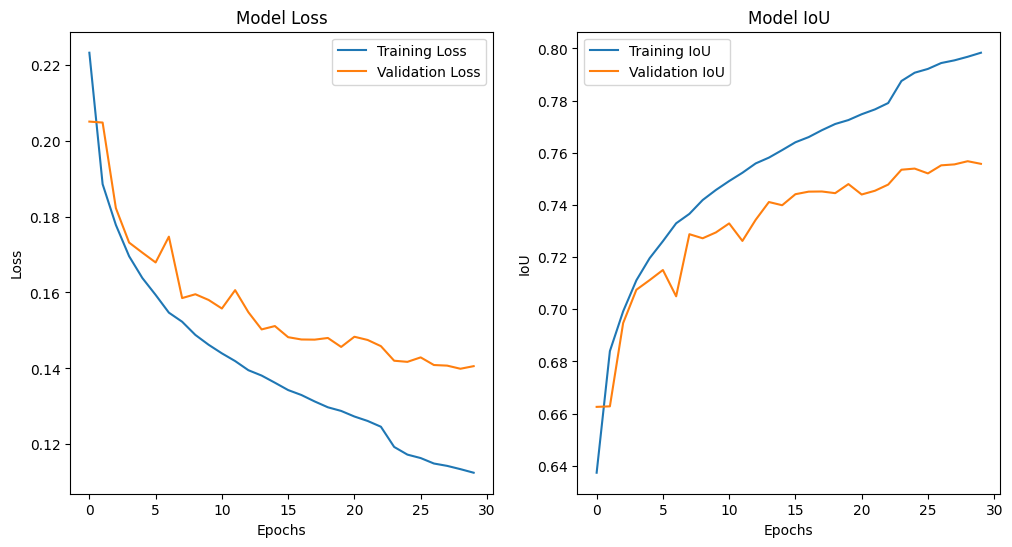

In [ ]:

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['jacard_coef'], label='Training IoU')
plt.plot(history.history['val_jacard_coef'], label='Validation IoU')
plt.title('Model IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.show()




# testing Unet

Found 3708 images belonging to 1 classes.
Found 3708 images belonging to 1 classes.
232/232 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.9321 - jacard_coef: 0.7497 - loss: 0.1441
Test Loss: 0.13977020978927612
Test Accuracy: 0.9277342557907104
Test Jaccard Coefficient (IoU): 0.7568275928497314
Inference time per image: 0.0048 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


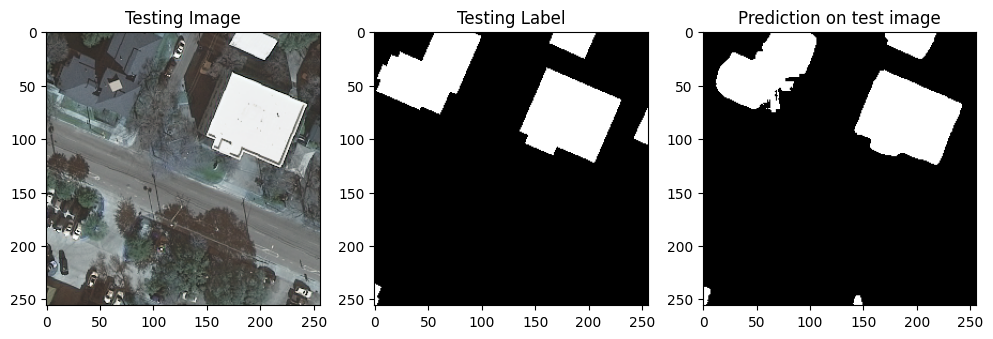

In [ ]:
#model can be loaded here for testing, correct file path to the loaded model needs to be given below in the load arguemnt
model = tf.keras.models.load_model('unet_model.h5')





seed = 42

test_data_gen_args = dict(
      rescale=1./255
  )

test_data_generator = ImageDataGenerator(**test_data_gen_args)




test_image_generator = test_data_generator.flow_from_directory(
      "/content/Data/test_images/",
      seed=seed,
      batch_size=batch_size,
      class_mode=None,
      shuffle=False
    )


test_mask_generator = test_data_generator.flow_from_directory(
      "/content/Data/test_masks/",
      seed=seed,
      batch_size=batch_size,
      color_mode='grayscale',
      class_mode=None,
      shuffle=False
    )

def my_image_mask_generator(image_gen, mask_gen):
      while True:
          for (img, mask) in zip(image_gen, mask_gen):

              yield (img, mask)


test_generator = my_image_mask_generator(test_image_generator, test_mask_generator)
num_test_images = len(test_image_generator.filenames)

start_time = time.time()
test_loss, test_accuracy, test_jaccard = model.evaluate(test_generator, steps=len(test_image_generator), verbose=1)
end_time = time.time()


total_inference_time = end_time - start_time
inference_time_per_image = total_inference_time / num_test_images


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Jaccard Coefficient (IoU): {test_jaccard}")
print(f"Inference time per image: {inference_time_per_image} seconds")


threshold = 0.5

test_image_batch, test_mask_batch = next(test_generator)

test_pred_batch = model.predict(test_image_batch)

binary_mask = (test_pred_batch > threshold).astype(np.uint8)

img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch[img_num], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(binary_mask [img_num],  cmap='gray')
plt.show()





# Loading data training and validation data for attention U-net

In [ ]:

batch_size = 16
train_generator, val_generator = create_generators(batch_size)


Found 29652 images belonging to 1 classes.
Found 29652 images belonging to 1 classes.
Found 3706 images belonging to 1 classes.
Found 3706 images belonging to 1 classes.


# Attention-Unet

In [ ]:
atten_model = models.att_unet_2d(input_shape, filter_num=[64, 128, 256, 512,1024], n_labels=num_classes,
                           stack_num_down=2, stack_num_up=2, activation='ReLU',
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid',
                           batch_norm=True, pool=False,  unpool='False',
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='attunet')






atten_model.summary()



atten_model.compile(loss=losses.dice, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', jacard_coef])


t0 = time.time()

history = atten_model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=epochs,
                    shuffle=False,
                    callbacks=[ early_stop, reduce_lr])

print("Training time:", time.time()-t0)


atten_model.save('atten_model.h5')








files.download('atten_model.h5')


/usr/local/lib/python3.10/dist-packages/keras_unet_collection/_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "attunet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ VGG16_backbone            │ [(None, 256, 256, 64), │     14,714,688 │ input_layer[0][0]      │
│ (Functional)              │ (None, 128, 128, 128), │                │                        │
│                           │ (None, 64, 64, 256),   │                │                        │
│                           │ (None, 32, 32, 512),   │                │                        │
│                           │ (None, 16, 16, 512)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_decode_unpool │ (None, 32, 32, 512)    │              0 │ VGG16_backbone[0][4]   │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_att_theta_x   │ (None, 32, 32, 256)    │        131,328 │ VGG16_backbone[0][3]   │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_att_phi_g     │ (None, 32, 32, 256)    │        131,328 │ attunet_up0_decode_un… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_att_add (Add) │ (None, 32, 32, 256)    │              0 │ attunet_up0_att_theta… │
│                           │                        │                │ attunet_up0_att_phi_g… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_att_activati… │ (None, 32, 32, 256)    │              0 │ attunet_up0_att_add[0… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_att_psi_f     │ (None, 32, 32, 1)      │            257 │ attunet_up0_att_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_att_sigmoid   │ (None, 32, 32, 1)      │              0 │ attunet_up0_att_psi_f… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_att_masking   │ (None, 32, 32, 512)    │              0 │ VGG16_backbone[0][3],  │
│ (Multiply)                │                        │                │ attunet_up0_att_sigmo… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_concat        │ (None, 32, 32, 1024)   │              0 │ attunet_up0_decode_un… │
│ (Concatenate)             │                        │                │ attunet_up0_att_maski… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_conv_after_c… │ (None, 32, 32, 512)    │      4,718,592 │ attunet_up0_concat[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attunet_up0_conv_afte

 Total params: 25,289,509 (96.47 MB)

 Trainable params: 10,570,981 (40.33 MB)

 Non-trainable params: 14,718,528 (56.15 MB)

Epoch 1/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 280s 126ms/step - accuracy: 0.8523 - jacard_coef: 0.5909 - loss: 0.2603 - val_accuracy: 0.8927 - val_jacard_coef: 0.6594 - val_loss: 0.2073 - learning_rate: 0.0010
Epoch 2/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 205s 111ms/step - accuracy: 0.8934 - jacard_coef: 0.6731 - loss: 0.1962 - val_accuracy: 0.8831 - val_jacard_coef: 0.6585 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 3/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 205s 111ms/step - accuracy: 0.9004 - jacard_coef: 0.6922 - loss: 0.1827 - val_accuracy: 0.9064 - val_jacard_coef: 0.6962 - val_loss: 0.1810 - learning_rate: 0.0010
Epoch 4/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 205s 111ms/step - accuracy: 0.9065 - jacard_coef: 0.7094 - loss: 0.1707 - val_accuracy: 0.9087 - val_jacard_coef: 0.6980 - val_loss: 0.1799 - learning_rate: 0.0010
Epoch 5/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 205s 111ms/step - accuracy: 0.9105 - jacard_coef: 0.7198 - loss: 0.1636 - val_accuracy: 0.9121 - val_jacard_coef: 0.7095 - val_loss: 0

Training time: 6233.037811756134


NameError: name 'training_time' is not defined

# plotting traning and validation curve

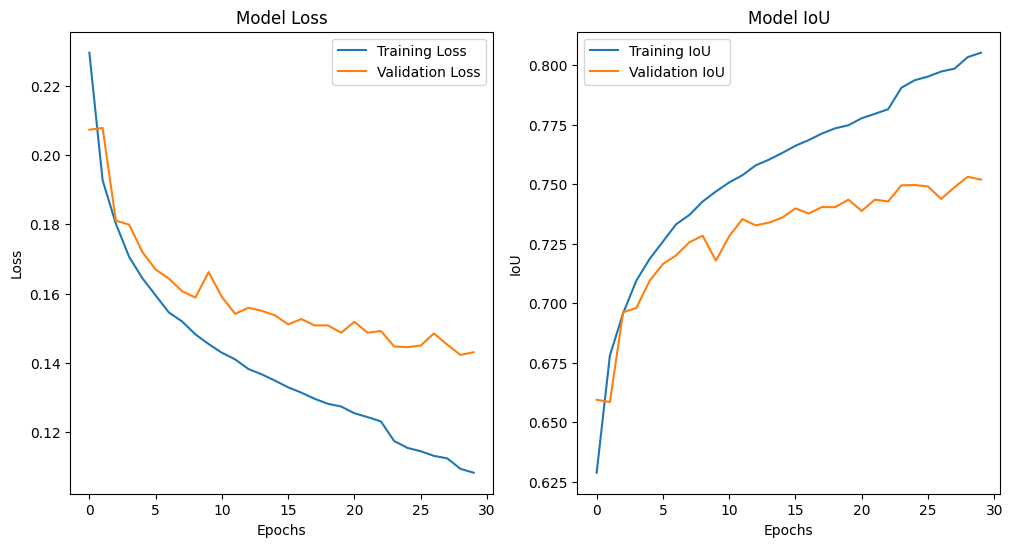

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['jacard_coef'], label='Training IoU')
plt.plot(history.history['val_jacard_coef'], label='Validation IoU')
plt.title('Model IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.show()


# Testing

Found 3708 images belonging to 1 classes.
Found 3708 images belonging to 1 classes.
232/232 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9317 - jacard_coef: 0.7464 - loss: 0.1464
Test Loss: 0.1422397494316101
Test Accuracy: 0.9269647002220154
Test Jaccard Coefficient (IoU): 0.7530866861343384
Inference time per image: 0.0032 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


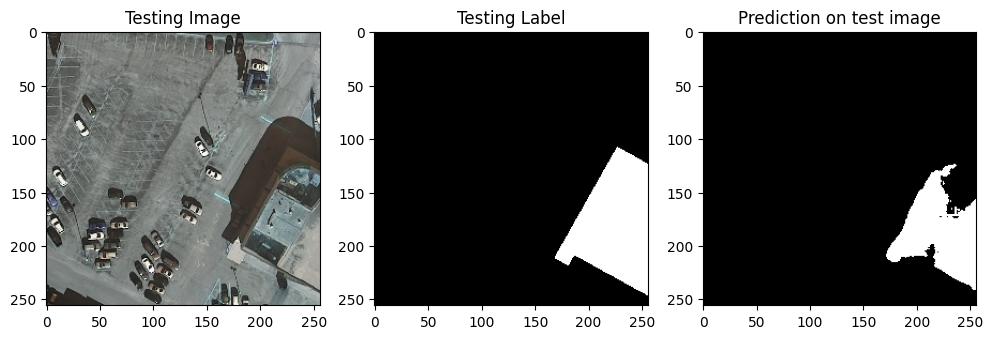

In [ ]:



atten_model = tf.keras.models.load_model('atten_model.h5')


seed = 42

test_data_gen_args = dict(
      rescale=1./255
  )

test_data_generator = ImageDataGenerator(**test_data_gen_args)




test_image_generator = test_data_generator.flow_from_directory(
      "/content/Data/test_images/",
      seed=seed,
      batch_size=batch_size,
      class_mode=None,
      shuffle=False
    )


test_mask_generator = test_data_generator.flow_from_directory(
      "/content/Data/test_masks/",
      seed=seed,
      batch_size=batch_size,
      color_mode='grayscale',
      class_mode=None,
      shuffle=False
    )

def my_image_mask_generator(image_gen, mask_gen):
      while True:
          for (img, mask) in zip(image_gen, mask_gen):


              yield (img, mask)


test_generator = my_image_mask_generator(test_image_generator, test_mask_generator)
num_test_images = len(test_image_generator.filenames)
start_time = time.time()
# Evaluate the model on the test set
test_loss, test_accuracy, test_jaccard = atten_model.evaluate(test_generator, steps=len(test_image_generator), verbose=1)
end_time = time.time()
total_inference_time = end_time - start_time
inference_time_per_image = total_inference_time / num_test_images

# Output the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Jaccard Coefficient (IoU): {test_jaccard}")
print(f"Inference time per image: {inference_time_per_image} seconds")


threshold = 0.5

test_image_batch, test_mask_batch = next(test_generator)

test_pred_batch = atten_model.predict(test_image_batch)

binary_mask = (test_pred_batch > threshold).astype(np.uint8)

img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch[img_num], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(binary_mask [img_num],  cmap='gray')
plt.show()



# 3+U-net

In [ ]:
batch_size = 16
train_generator, val_generator = create_generators(batch_size)

Found 29652 images belonging to 1 classes.
Found 29652 images belonging to 1 classes.
Found 3706 images belonging to 1 classes.
Found 3706 images belonging to 1 classes.


In [ ]:
three_plus_model = models.unet_3plus_2d(input_shape,filter_num_down=[64, 128, 256, 512,1024], n_labels=num_classes,
                             filter_num_skip='auto', filter_num_aggregate='auto',
                             stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool=False, unpool=False,backbone='VGG16', weights='imagenet',freeze_backbone=True, freeze_batch_norm=True, deep_supervision=True, name='unet3plus')





metrics_list = ['accuracy', jacard_coef]

three_plus_model.summary()
three_plus_model.compile(loss=losses.dice, optimizer=Adam(learning_rate=0.001), metrics=[metrics_list] * 5)


t0 = time.time()

history = three_plus_model .fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    verbose=1,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=epochs,
                    shuffle=False,
                    callbacks=[ early_stop, reduce_lr])



print("Training time:", time.time()-t0)


three_plus_model.save('three_plus_model .h5')


Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 320
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	unet3plus_output_sup0_activation
	unet3plus_output_sup1_activation
	unet3plus_output_sup2_activation
	unet3plus_output_sup3_activation
	unet3plus_output_final_activation


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ VGG16_backbone            │ [(None, 256, 256, 64), │     14,714,688 │ input_layer_4[0][0]    │
│ (Functional)              │ (None, 128, 128, 128), │                │                        │
│                           │ (None, 64, 64, 256),   │                │                        │
│                           │ (None, 32, 32, 512),   │                │                        │
│                           │ (None, 16, 16, 512)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_up_0_en0_trans… │ (None, 32, 32, 64)     │        294,976 │ VGG16_backbone[0][4]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down_0_en2_str… │ (None, 32, 32, 64)     │         65,536 │ VGG16_backbone[0][2]   │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down_0_en3_str… │ (None, 32, 32, 64)     │        131,072 │ VGG16_backbone[0][1]   │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_up_0_en0_bn     │ (None, 32, 32, 64)     │            256 │ unet3plus_up_0_en0_tr… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down_0_en2_bn   │ (None, 32, 32, 64)     │            256 │ unet3plus_down_0_en2_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down_0_en3_bn   │ (None, 32, 32, 64)     │            256 │ unet3plus_down_0_en3_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_up_0_en0_activ… │ (None, 32, 32, 64)     │              0 │ unet3plus_up_0_en0_bn… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down_0_en2_act… │ (None, 32, 32, 64)     │              0 │ unet3plus_down_0_en2_… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down_0_en3_act… │ (None, 32, 32, 64)     │              0 │ unet3plus_down_0_en3_… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ unet3plus_down_from0_to0… │ (None, 32, 32, 64)     │         36,864 │ unet3plus_up_0_en0_ac… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,894,957 (94.97 MB)

 Trainable params: 10,171,437 (38.80 MB)

 Non-trainable params: 14,723,520 (56.17 MB)

Epoch 1/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 399s 170ms/step - loss: 0.2699 - unet3plus_output_sup0_activation_accuracy: 0.8375 - unet3plus_output_sup0_activation_jacard_coef: 0.5828 - val_loss: 0.1945 - val_unet3plus_output_sup0_activation_accuracy: 0.8999 - val_unet3plus_output_sup0_activation_jacard_coef: 0.6773 - learning_rate: 0.0010
Epoch 2/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 276s 149ms/step - loss: 0.1838 - unet3plus_output_sup0_activation_accuracy: 0.9000 - unet3plus_output_sup0_activation_jacard_coef: 0.6907 - val_loss: 0.1832 - val_unet3plus_output_sup0_activation_accuracy: 0.8993 - val_unet3plus_output_sup0_activation_jacard_coef: 0.6928 - learning_rate: 0.0010
Epoch 3/30
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 276s 149ms/step - loss: 0.1699 - unet3plus_output_sup0_activation_accuracy: 0.9076 - unet3plus_output_sup0_activation_jacard_coef: 0.7108 - val_loss: 0.1796 - val_unet3plus_output_sup0_activation_accuracy: 0.9050 - val_unet3plus_output_sup0_activation_jacard_coef: 0.6986 - learning

Training time: 8392.327454805374


# PLotting validation and traning curves

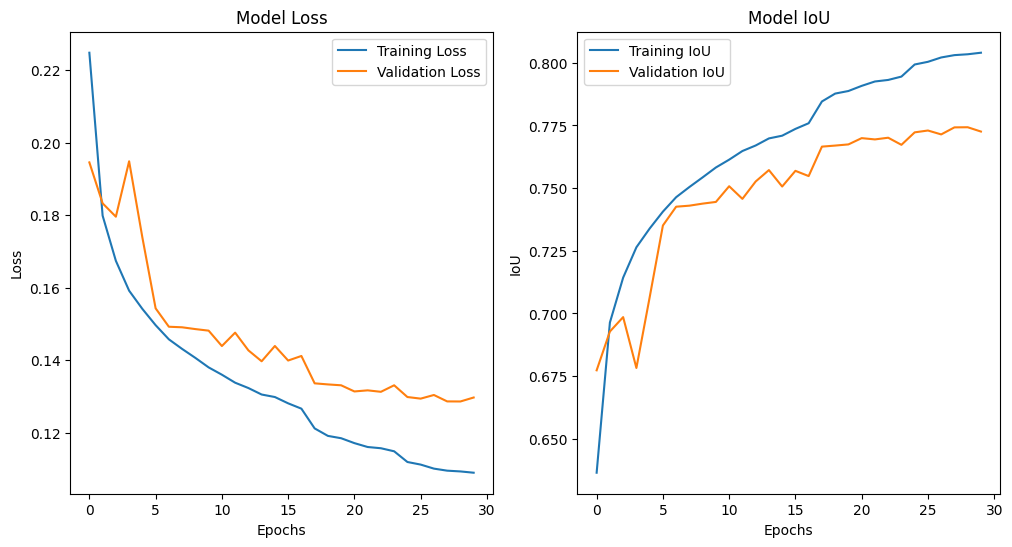

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['unet3plus_output_sup0_activation_jacard_coef'], label='Training IoU')
plt.plot(history.history['val_unet3plus_output_sup0_activation_jacard_coef'], label='Validation IoU')
plt.title('Model IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.show()

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'unet3plus_output_sup0_activation_accuracy', 'unet3plus_output_sup0_activation_jacard_coef', 'val_loss', 'val_unet3plus_output_sup0_activation_accuracy', 'val_unet3plus_output_sup0_activation_jacard_coef', 'learning_rate'])


# Testing

Found 3708 images belonging to 1 classes.
Found 3708 images belonging to 1 classes.
232/232 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.1316 - unet3plus_output_sup0_activation_accuracy: 0.9379 - unet3plus_output_sup0_activation_jacard_coef: 0.7692
Test Loss: 0.1285950392484665
Test Accuracy: 0.9335231184959412
Test Jaccard Coefficient (IoU): 0.7742921710014343
Inference time per image: 0.0023 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


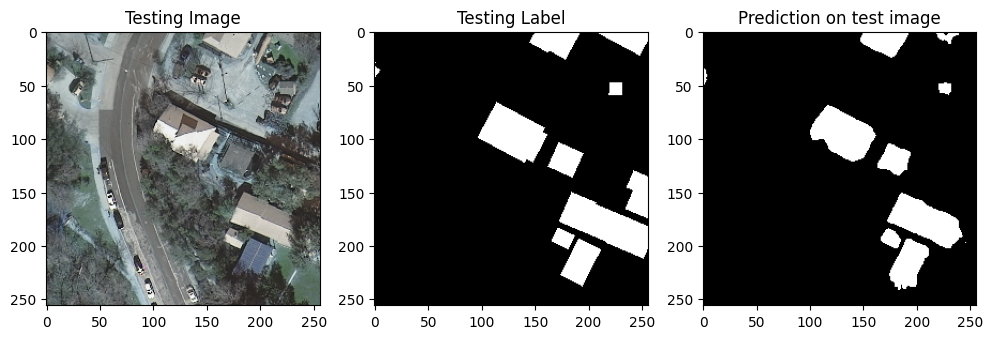

In [ ]:



three_plus_model = tf.keras.models.load_model('atten_model.h5')


seed = 42

test_data_gen_args = dict(
      rescale=1./255
  )

test_data_generator = ImageDataGenerator(**test_data_gen_args)




test_image_generator = test_data_generator.flow_from_directory(
      "/content/Data/test_images/",
      seed=seed,
      batch_size=batch_size,
      class_mode=None,
      shuffle=False
    )


test_mask_generator = test_data_generator.flow_from_directory(
      "/content/Data/test_masks/",
      seed=seed,
      batch_size=batch_size,
      color_mode='grayscale',
      class_mode=None,
      shuffle=False
    )

def my_image_mask_generator(image_gen, mask_gen):
      while True:
          for (img, mask) in zip(image_gen, mask_gen):


              yield (img, mask)


test_generator = my_image_mask_generator(test_image_generator, test_mask_generator)
num_test_images = len(test_image_generator.filenames)
start_time = time.time()


test_loss, test_accuracy, test_jaccard = three_plus_model.evaluate(test_generator, steps=len(test_image_generator), verbose=1)
end_time = time.time()
total_inference_time = end_time - start_time
inference_time_per_image = total_inference_time / num_test_images


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Jaccard Coefficient (IoU): {test_jaccard}")
print(f"Inference time per image: {inference_time_per_image} seconds")


threshold = 0.5

test_image_batch, test_mask_batch = next(test_generator)

predictions = three_plus_model.predict(test_image_batch)
test_pred_batch = predictions[0]
binary_mask = (test_pred_batch > threshold).astype(np.uint8)

img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch[img_num], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(binary_mask [img_num],  cmap='gray')
plt.show()



In [ ]:

files.download('three_plus_model .h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>